In [32]:
import pandas as pd
import torch
from torch_geometric.data import Data
import numpy as np
from thesis_floor_halkes.data_processing.open_street_map_coords import create_node_coordinates_dataframe_from_osmnx_graph, create_osmnx_subgraph_from_coordinates
import osmnx as ox
ox.settings.bidirectional_network_types = ['drive', 'walk', 'bike']



def get_static_data_object(final_node_df, final_edge_df):
    node_for_coords_graph = final_node_df.sample(1)
    lat = node_for_coords_graph.iloc[0]['lat']
    lon = node_for_coords_graph.iloc[0]['lon']
    
    graph = create_osmnx_subgraph_from_coordinates(lat, lon, dist=500)
    nodes = create_node_coordinates_dataframe_from_osmnx_graph(graph)
    df_filtered = final_node_df.merge(nodes, on=['lat', 'lon'], how='inner')
    
    nodes_idx = df_filtered.set_index('node_id_x')
    mask_u = final_edge_df['u'].isin(nodes_idx.index)
    mask_v = final_edge_df['v'].isin(nodes_idx.index)
    filtered_edges = final_edge_df[mask_u & mask_v]
    
        # 1) Build your cleaned & sorted node list
    static_node_df = (
        df_filtered
        .drop_duplicates(subset='node_id_x', keep='first')
        .sort_values('node_id_x')
    )

    # 2) Create a mapping old_id → new_id (0…N-1)
    orig_ids = static_node_df['node_id_x'].to_numpy()
    old2new = {old: new for new, old in enumerate(orig_ids)}

    # 3) Map your edges into the new index space
    u_new = filtered_edges['u'].map(old2new).to_numpy()
    v_new = filtered_edges['v'].map(old2new).to_numpy()

    # 4) Build your tensors
    x = torch.from_numpy(
        static_node_df[['lat','lon','has_light']].to_numpy(dtype=np.float32)
    )
    
    edge_index = torch.from_numpy(np.vstack([u_new, v_new])).long()
    edge_attr = torch.from_numpy(
        filtered_edges[['length','maxspeed']].to_numpy(dtype=np.float32)
    )
    
    orig_id=torch.from_numpy(orig_ids).long()
    
    # # 4) Remap u/v → contiguous 0…N-1 and make them torch tensors
    # u = torch.tensor(filtered_edges['u'].map(old2new).tolist(), dtype=torch.long)
    # v = torch.tensor(filtered_edges['v'].map(old2new).tolist(), dtype=torch.long)

    # # 5) Duplicate edges for undirected traversal
    # edge_index = torch.cat([
    #     torch.stack([u, v], dim=0),
    #     torch.stack([v, u], dim=0)
    # ], dim=1)  # shape: (2, 2E)

    # # 6) Edge attributes (length, maxspeed), duplicated as well
    # edge_attr_single = torch.tensor(
    #     filtered_edges[['length','maxspeed']].values,
    #     dtype=torch.float32
    # )  # shape: (E, 2)
    # edge_attr = torch.cat([edge_attr_single, edge_attr_single], dim=0)  # (2E, 2)

    # # 7) Node features x = [lat, lon, has_light]
    # x = torch.tensor(
    #     static_node_df[['lat','lon','has_light']].values,
    #     dtype=torch.float32
    # )  # shape: (N, 3)
    
    
     
    # 5) If you ever need original IDs later, stick them on:
    static_data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        orig_id=orig_id,
    )
    
    num_nodes = static_data.x.size(0)
    static_data.start_node = torch.randint(0, num_nodes, (1,)).item()
    static_data.end_node   = torch.randint(0, num_nodes, (1,)).item()
    
    while static_data.start_node == static_data.end_node: 
        static_data.end_node   = torch.randint(0, num_nodes, (1,)).item()
    static_data.sub_nodes_df = df_filtered
    
    return static_data


final_node_df = pd.read_parquet("data/processed/node_features.parquet")
final_edge_df = pd.read_parquet("data/processed/edge_features_helmond.parquet")

static_data = get_static_data_object(final_node_df, final_edge_df)

ImportError: cannot import name 'create_osmnx_subgraph_from_coordinates' from 'thesis_floor_halkes.data_processing.open_street_map_coords' (/home/jens/projects/floor_projects/scriptie_floor/thesis_floor_halkes/thesis_floor_halkes/data_processing/open_street_map_coords.py)

In [19]:
import networkx as nx

def create_osmnx_graph_from_place(place):
    G = ox.graph_from_place(place, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
    # G = G.to_undirected()
    G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)
    return G

def create_osmnx_subgraph_from_coordinates(lat,lon, dist):
    G = ox.graph_from_point((lat, lon), dist=dist, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
    # G = G.to_undirected()
    G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)
    
    return G

g = create_osmnx_subgraph_from_coordinates(51.477437, 5.657535, 50)
print(g.edges())
print(list(set(g.edges())))

[(0, 1), (1, 2), (1, 6), (1, 5), (1, 0), (2, 1), (2, 3), (2, 7), (2, 4), (3, 2), (4, 2), (5, 1), (6, 7), (6, 1), (7, 6), (7, 2)]
[(0, 1), (2, 4), (1, 2), (2, 1), (2, 7), (1, 5), (6, 1), (5, 1), (4, 2), (2, 3), (6, 7), (7, 6), (7, 2), (1, 0), (1, 6), (3, 2)]


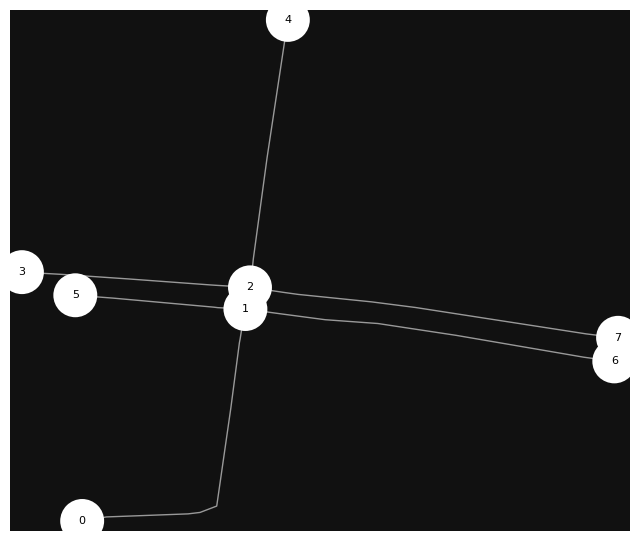

In [13]:
import matplotlib.pyplot as plt
# 1. Plot the graph but don’t close or show it yet
fig, ax = ox.plot_graph(g, show=False, close=False, node_size=1000)

# 2a. Method 1: loop through nodes and add text at each x, y
for node, data in g.nodes(data=True):
    x, y = data['x'], data['y']
    ax.text(x, y, str(node), fontsize=8, ha='center', va='center', zorder=3)

# 2b. (Alternative) Method 2: use NetworkX’s draw_networkx_labels
# pos = {n: (d['x'], d['y']) for n, d in G.nodes(data=True)}
# nx.draw_networkx_labels(G, pos, labels={n: n for n in G.nodes()},
#                         font_size=8, ax=ax, zorder=4)

# 3. Finally show the plot
plt.show()


In [2]:
import pandas as pd
final_node_df = pd.read_parquet("data/processed/node_features.parquet")
# final_edge_df = pd.read_parquet("data/processed/edge_features_helmond.parquet")
# print(final_edge_df.shape)
# print(final_node_df.head())
print(final_node_df.loc[final_node_df['has_light']==1])

           node_id tlc_name        lat       lon  has_light  distance_m  \
4800      42664392   HEL614  51.452332  5.685176          1    7.513763   
4801      42664392   HEL614  51.452332  5.685176          1    7.513763   
4802      42664392   HEL614  51.452332  5.685176          1    7.513763   
4803      42664392   HEL614  51.452332  5.685176          1    7.513763   
4804      42664392   HEL614  51.452332  5.685176          1    7.513763   
...            ...      ...        ...       ...        ...         ...   
376507  9164837606   HEL211  51.485667  5.656869          1   21.063672   
376508  9164837606   HEL211  51.485667  5.656869          1   21.063672   
376509  9164837606   HEL211  51.485667  5.656869          1   21.063672   
376510  9164837606   HEL211  51.485667  5.656869          1   21.063672   
376511  9164837606   HEL211  51.485667  5.656869          1   21.063672   

                 timestamp  wait_time  
4800   2024-01-31 00:00:00       0.00  
4801   2024-01-31 0

In [11]:
import osmnx as ox 
import networkx as nx
import torch 
from torch_geometric.data import Data
import numpy as np


def build_data_object(
    time_series_df_path: str,
    edge_df_path: str,
    dist: int = 500,
    start_node: int = None,
    end_node: int = None,
    seed: int = None,
):
    # get full time series dataframe
    time_series = pd.read_parquet(time_series_df_path)
    
    # get full edge dataframe
    # edge_df = pd.read_parquet(edge_df_path)
    
    # select a random location from full timeseries dataframe
    location = time_series.sample(1, random_state=seed)
    lat = location.iloc[0]["lat"]
    lon = location.iloc[0]["lon"]
    
    # create subgraph based on random location
    graph = create_osmnx_subgraph_from_coordinates(lat, lon, dist=dist)
    
    edge_features = get_edge_features_from_osmnx(graph).reset_index()
    print(f"{edge_features= }")
        
    # filter time series dataframe based on nodes from subgraph
    subgraph_nodes_df = create_node_coordinates_dataframe_from_osmnx_graph(graph)
    print(f"{subgraph_nodes_df= }")
    print(time_series.loc[time_series["lat"]==51.458019])
    filtered_time_series_df = time_series.merge(
        subgraph_nodes_df, left_on=["lat", "lon"], right_on=["lat", "lon"], how="inner"
    )
    print(filtered_time_series_df.loc[filtered_time_series_df["has_light"]==1])
    print(f"{filtered_time_series_df= }")
    # subset edge dataframe based on nodes from subgraph
    # filtered_edge_df = edge_features[
    #     edge_features["u"].isin(filtered_time_series_df.node_id)
    #     & edge_features["v"].isin(filtered_time_series_df.node_id)
    # ]
    # print(filtered_edge_df)
    
    # build edge index
    edge_index = torch.tensor(
        edge_features[["u", "v"]].values, dtype=torch.long
    ).t().contiguous()

    # build static edge attributes
    edge_attr = torch.tensor(
        edge_features[["length", "maxspeed"]].values, dtype=torch.float
    )

    # build static node features
    node_features = filtered_time_series_df.drop_duplicates(subset=["node_id_y"]).copy()
    print(f"{node_features= }")
    node_features = torch.tensor(
        node_features[["lat", "lon", "has_light"]].values, dtype=torch.float
    )
    
    # build static data object
    static_data = Data(
        x=node_features,
        edge_index=edge_index,
        edge_attr=edge_attr,
    )
    
    
    # add filtered time series dataframe to static data object
    static_data.filtered_time_series_df = filtered_time_series_df
    
    # add start and end node to static data object
    if start_node is None:
        # randomly select start node
        start_node = np.random.choice(filtered_time_series_df.node_id_y.values)
    if end_node is None:
        # randomly select end node
        end_node = np.random.choice(filtered_time_series_df.node_id_y.values)
        while start_node == end_node:
            end_node = np.random.choice(filtered_time_series_df.node_id_y.values)
    static_data.start_node = start_node
    static_data.end_node = end_node

    # add filtered edge dataframe to static data object
    static_data.filtered_edge_df = edge_features

    print(f"{static_data.start_node= }")
    
    return static_data


def create_osmnx_subgraph_from_coordinates(lat,lon, dist):
    G = ox.graph_from_point((lat, lon), dist=dist, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
    # G = G.to_undirected()
    # G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)
    
    return G

def create_node_coordinates_dataframe_from_osmnx_graph(G):
    G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)
    nodes, _ = ox.graph_to_gdfs(G)
    
    nodes = nodes[['y', 'x']].reset_index(names='node_id')
    nodes = nodes.rename(columns={'y': 'lat', 'x': 'lon'})
    return nodes

def clean_numeric(val, default=50.0):
    if isinstance(val, list):
        val = val[0]  # If it's a list, pick the first value
    try:
        return float(val)
    except (ValueError, TypeError):
        return default 

def get_edge_features_from_osmnx(G):
    G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)    
    _, edges = ox.graph_to_gdfs(G)
    
    edges = edges[['maxspeed', 'length']]
    edges['maxspeed'] = edges['maxspeed'].apply(lambda x: clean_numeric(x, default=50.0))
    edges['length'] = edges['length'].apply(lambda x: clean_numeric(x, default=30.0))  # 30m as a reasonable default)
    edges['maxspeed'] = edges['maxspeed'].fillna(50.0)
    edges['length'] = edges['length'].fillna(30.0)
    
    return edges

    
build_data_object(
    time_series_df_path="data/processed/node_features.parquet",
    edge_df_path="data/processed/edge_features_helmond.parquet",
    dist=1000,
    seed=5,
)

edge_features=        u    v  key  maxspeed       length
0      0    3    0      50.0   903.614680
1      1    5    0      50.0   877.872769
2      2   10    0      60.0  1082.480729
3      3    6    0      50.0   188.047632
4      3    0    0      50.0   903.614680
..   ...  ...  ...       ...          ...
972  431  330    0      50.0    84.441902
973  432  145    0      30.0   133.539137
974  432  120    0      30.0    88.408587
975  432  116    0      30.0    78.743826
976  433  140    0      30.0   109.342631

[977 rows x 5 columns]
subgraph_nodes_df=      node_id        lat       lon
0          0  51.458019  5.671677
1          1  51.458326  5.665498
2          2  51.458390  5.671940
3          3  51.464485  5.663799
4          4  51.465350  5.669330
..       ...        ...       ...
429      429  51.474770  5.675423
430      430  51.474902  5.675046
431      431  51.481240  5.656078
432      432  51.475518  5.656588
433      433  51.476662  5.657932

[434 rows x 3 columns]
Empty 

Data(x=[428, 3], edge_index=[2, 977], edge_attr=[977, 2], filtered_time_series_df=         node_id_x tlc_name        lat       lon  has_light  distance_m  \
0         42698741        0  51.464485  5.663799          0  164.586816   
1         42698741        0  51.464485  5.663799          0  164.586816   
2         42698741        0  51.464485  5.663799          0  164.586816   
3         42698741        0  51.464485  5.663799          0  164.586816   
4         42698741        0  51.464485  5.663799          0  164.586816   
...            ...      ...        ...       ...        ...         ...   
41083  12334296444        0  51.476662  5.657932          0   90.472726   
41084  12334296444        0  51.476662  5.657932          0   90.472726   
41085  12334296444        0  51.476662  5.657932          0   90.472726   
41086  12334296444        0  51.476662  5.657932          0   90.472726   
41087  12334296444        0  51.476662  5.657932          0   90.472726   

                t

In [70]:
def clean_numeric(val, default=50.0):
    if isinstance(val, list):
        val = val[0]  # If it's a list, pick the first value
    try:
        return float(val)
    except (ValueError, TypeError):
        return default 
    
def get_edge_features_from_osmnx(place):
    G = create_osmnx_graph_from_place(place)
    
    _, edges = ox.graph_to_gdfs(G)
    
    edges = edges[['maxspeed', 'length']]
    edges['maxspeed'] = edges['maxspeed'].apply(lambda x: clean_numeric(x, default=50.0))
    edges['length'] = edges['length'].apply(lambda x: clean_numeric(x, default=30.0))  # 30m as a reasonable default)
    edges['maxspeed'] = edges['maxspeed'].fillna(50.0)
    edges['length'] = edges['length'].fillna(30.0)
    print(edges)
    
    return edges.reset_index()

edge = get_edge_features_from_osmnx("Helmond, Netherlands")

               maxspeed       length
u    v    key                       
0    1654 0        60.0  1741.892947
1    3893 0        60.0   465.934174
2    2010 0        30.0   204.948959
     1940 0        30.0   160.302923
          1        30.0   402.233533
...                 ...          ...
4025 668  0        30.0    77.748379
     4026 0        30.0    28.853352
4026 4025 0        30.0    28.853352
4027 1357 0        30.0   109.342631
4028 2384 0        50.0    16.796694

[11606 rows x 2 columns]


In [71]:
edge

,u,v,key,maxspeed,length
0,0,1654,0,60.0,1741.892947
1,1,3893,0,60.0,465.934174
2,2,2010,0,30.0,204.948959
3,2,1940,0,30.0,160.302923
4,2,1940,1,30.0,402.233533
...,...,...,...,...,...
11601,4025,668,0,30.0,77.748379
11602,4025,4026,0,30.0,28.853352
11603,4026,4025,0,30.0,28.853352
11604,4027,1357,0,30.0,109.342631


In [78]:
ox.settings.bidirectional_network_types = ['drive', 'walk', 'bike']

def create_osmnx_graph_from_place(place):
    G = ox.graph_from_place(place, network_type='drive', simplify=True, retain_all=False, truncate_by_edge=True)
    # G = G.to_undirected()
    G = nx.convert_node_labels_to_integers(G, ordering='sorted', first_label=0)
    return G

_g = create_osmnx_graph_from_place("Helmond, Netherlands")
print(_g.edges())
print(len(_g.edges()))

[(0, 1654), (1, 3893), (2, 2010), (2, 1940), (2, 1940), (3, 2085), (4, 2145), (5, 2636), (5, 2599), (5, 2632), (6, 12), (7, 34), (8, 3793), (8, 2773), (8, 2713), (9, 11), (9, 3814), (9, 3829), (10, 2774), (10, 3828), (10, 3829), (11, 3828), (11, 3829), (11, 9), (11, 3827), (12, 6), (12, 2775), (12, 15), (13, 3820), (13, 3819), (13, 3825), (13, 3826), (14, 2770), (14, 23), (14, 3805), (15, 27), (15, 3795), (15, 12), (16, 43), (16, 677), (16, 3926), (17, 3825), (17, 3823), (17, 22), (18, 3669), (19, 3798), (19, 3794), (19, 20), (19, 3639), (20, 19), (20, 3798), (20, 21), (21, 24), (21, 24), (21, 20), (22, 3823), (22, 3824), (22, 3821), (22, 17), (23, 3797), (23, 45), (23, 14), (24, 21), (24, 21), (24, 25), (25, 3823), (25, 24), (25, 3824), (26, 54), (26, 3306), (26, 3393), (27, 4017), (27, 28), (27, 15), (28, 27), (28, 3822), (28, 3821), (29, 53), (30, 2788), (30, 3796), (30, 2791), (30, 33), (31, 32), (31, 2666), (31, 2663), (32, 31), (32, 2670), (32, 2671), (33, 2789), (33, 30), (33, 3